<a href="https://colab.research.google.com/github/ChethanaVaisali/COVID_19/blob/master/COVID_19_squeezenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SqueezeNet For COVID-19**

### Import data

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
import keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Add, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import GlobalMaxPool2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import regularizers, optimizers

Using TensorFlow backend.


In [3]:
import numpy as np

train_x = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/train_x_256x256.npy')
train_y = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/train_y_256x256.npy')

valid_x = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/val_x_256x256.npy')
valid_y = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/val_y_256x256.npy')

test_x = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/test_x_256x256.npy')
test_y = np.load('/gdrive/My Drive/CV Assignment 2/Augmented_data/test_y_256x256.npy')

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(4136, 256, 256, 3) (4136,)
(1035, 256, 256, 3) (1035,)
(464, 256, 256, 3) (464,)


In [4]:
## Convert y to one hot encoding

train_y = keras.utils.to_categorical(train_y)
valid_y = keras.utils.to_categorical(valid_y)
test_y = keras.utils.to_categorical(test_y)

print(train_y.size, valid_y.size, test_y.size)

12408 3105 1392


In [0]:
train_x = train_x/255
valid_x  = valid_x/255
test_x = test_x/255

In [6]:
!pip install git+https://github.com/rcmalli/keras-squeezenet.git
!pip install keras_squeezenet

  Cloning https://github.com/rcmalli/keras-squeezenet.git to /tmp/pip-req-build-09rurjy1
  Running command git clone -q https://github.com/rcmalli/keras-squeezenet.git /tmp/pip-req-build-09rurjy1
  Created wheel for keras-squeezenet: filename=keras_squeezenet-0.4-cp36-none-any.whl size=4425 sha256=3983337940473fc329105b402eab4ae3a3eac34515e09a338c6ae11cbf93efc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_s_p1x7/wheels/15/75/ed/45fffbc76d921a5be07af533b774b35bbf40551334c51af91f
Successfully built keras-squeezenet


In [24]:
# Import model
from keras_squeezenet import SqueezeNet
sn_model = SqueezeNet(include_top = False, weights='imagenet',input_shape=(256,256,3))
sn_model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 127, 127, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 127, 127, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 63, 63, 64)   0           relu_conv1[0][0]                 
_________________________________________________________________________________________

In [0]:
# The addition of top layers
x = Flatten()(sn_model.layers[-1].output)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)

x = Dense(3, activation = 'softmax')(x)
model = Model(inputs = sn_model.input, outputs = x)

for layer in sn_model.layers:
  layer.trainable = False

for layer in sn_model.layers:
  if"BatchNormalization" in layer.__class__.__name__:
    layer.trainable = True



In [46]:
from keras.optimizers import Adam
opt = Adam(lr = 0.0003, decay = 0.0003/100)
model.compile(optimizer= opt , loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 127, 127, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 127, 127, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 63, 63, 64)   0           relu_conv1[0][0]                 
____________________________________________________________________________________________

In [47]:
mc = ModelCheckpoint('/gdrive/My Drive/Colab Notebooks/squeezenet.h5',monitor='val_loss', save_best_only = True, verbose = 1, mode='min')
es = EarlyStopping(monitor='val_loss', mode = 'min',patience = 15, verbose=1)
lr = ReduceLROnPlateau(factor=0.1, patience = 5, min_lr = 0.0000001, verbose = 1)
history = model.fit(train_x, train_y, batch_size = 64, epochs = 100, validation_data=(valid_x,valid_y), shuffle = True, callbacks = [es,lr, mc])

Train on 4136 samples, validate on 1035 samples
Epoch 1/100
4136/4136 [==============================] - 9s 2ms/step - loss: 18.2005 - accuracy: 0.3905 - val_loss: 2.4179 - val_accuracy: 0.4725

Epoch 00001: val_loss improved from inf to 2.41794, saving model to /gdrive/My Drive/Colab Notebooks/squeezenet.h5
Epoch 2/100
4136/4136 [==============================] - 9s 2ms/step - loss: 0.8012 - accuracy: 0.6922 - val_loss: 0.3475 - val_accuracy: 0.8570

Epoch 00002: val_loss improved from 2.41794 to 0.34751, saving model to /gdrive/My Drive/Colab Notebooks/squeezenet.h5
Epoch 3/100
4136/4136 [==============================] - 9s 2ms/step - loss: 0.4351 - accuracy: 0.8266 - val_loss: 0.4498 - val_accuracy: 0.7913

Epoch 00003: val_loss did not improve from 0.34751
Epoch 4/100
4136/4136 [==============================] - 9s 2ms/step - loss: 0.3596 - accuracy: 0.8641 - val_loss: 0.2322 - val_accuracy: 0.9179

Epoch 00004: val_loss improved from 0.34751 to 0.23224, saving model to /gdrive/My

<Figure size 432x288 with 0 Axes>

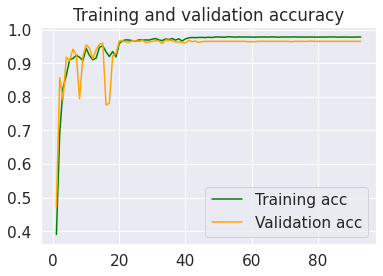

<Figure size 432x288 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)
plt.plot(epochs,acc, 'b', color='green', label = 'Training acc')
plt.plot(epochs,val_acc, 'b', color='orange', label = 'Validation acc')

plt.title('Training and validation accuracy')

plt.legend()

plt.figure()

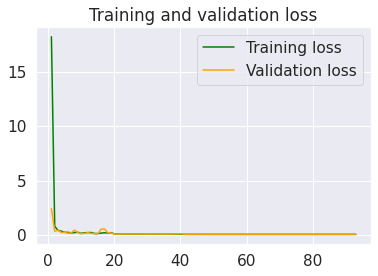

In [49]:
plt.plot(epochs, loss, 'b', color='green', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', color='orange', label = 'Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [50]:
model.load_weights('/gdrive/My Drive/Colab Notebooks/squeezenet.h5')
model.evaluate(train_x,train_y)

4136/4136 [==============================] - 6s 1ms/step


[0.06062631072328792, 0.9779980778694153]

In [51]:
model.evaluate(valid_x,valid_y)

1035/1035 [==============================] - 1s 1ms/step


[0.0821841712879098, 0.966183602809906]

In [52]:
model.evaluate(test_x,test_y)

464/464 [==============================] - 1s 1ms/step


[0.10657184031502955, 0.9612069129943848]

In [0]:
pred = model.predict(test_x)

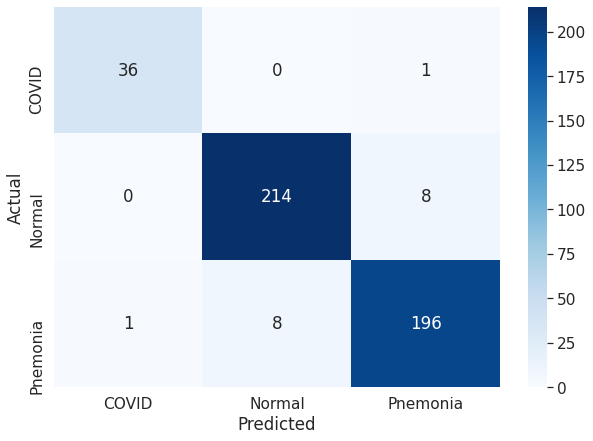

In [54]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y = np.argmax(test_y,axis = 1)
pred_y = np.argmax(pred,axis = 1)
data = confusion_matrix(y,pred_y)
df = pd.DataFrame(data, columns = ['COVID','Normal','Pnemonia'], index = ['COVID','Normal','Pnemonia'])
df.index.name = 'Actual'
df.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale = 1.4)
sns.heatmap(df, cmap = 'Blues', annot = True, fmt = "d")

In [55]:
from sklearn import metrics

print(metrics.classification_report(y,pred_y,labels = [0,1,2],target_names={'COVID' : 0,'Normal' : 1,'Pneumonia' : 2}, digits=4))

              precision    recall  f1-score   support

       COVID     0.9730    0.9730    0.9730        37
      Normal     0.9640    0.9640    0.9640       222
   Pneumonia     0.9561    0.9561    0.9561       205

    accuracy                         0.9612       464
   macro avg     0.9643    0.9643    0.9643       464
weighted avg     0.9612    0.9612    0.9612       464

